In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import ale_py  as ale
from PIL import Image
from collections import deque
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [3]:
class Actor(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [4]:
class Critic(nn.Module):
    def __init__(self, obs_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = self.fc2(x)
        return value

In [5]:
obs = env.reset()[0]
obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
print("Initial observation:", obs_tensor)
print("Observation tensor shape:", obs_tensor.shape)

Initial observation: tensor([[-0.0217,  0.0250,  0.0054, -0.0440]])
Observation tensor shape: torch.Size([1, 4])


In [6]:
actor = Actor(4,2)
critic = Critic(4)

logits = actor(obs_tensor)
value = critic(obs_tensor)

print("Actor logits:", logits)
print("Value:", value)

Actor logits: tensor([[-0.2044,  0.1958]], grad_fn=<AddmmBackward0>)
Value: tensor([[-0.1974]], grad_fn=<AddmmBackward0>)


In [7]:
def select_action(actor, obs):
    logits = actor(obs)
    dist = Categorical(logits=logits)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    entropy = dist.entropy()
    return action.item(), log_prob, entropy

In [8]:
action, log_prob, entropy = select_action(actor, obs_tensor)

print("Action:", action)
print("Log prob:", log_prob)
print("Entropy:", entropy)


Action: 1
Log prob: tensor([-0.5129], grad_fn=<SqueezeBackward1>)
Entropy: tensor([0.6735], grad_fn=<NegBackward0>)


In [9]:
#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

In [10]:
episodes = 300
gamma = 0.99

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

entropy_coef = 0.01


In [11]:
import matplotlib.pyplot as plt

#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

episodes = 300
gamma = 0.95

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)


entropy_coef = 0.0
# Storage for logs
reward_log = []
actor_loss_log = []
critic_loss_log = []
entropy_log = []

for episode in range(episodes):

    state, _ = env.reset()
    done = False
    episode_reward = 0
    episode_actor_loss = 0.0
    episode_critic_loss = 0.0
    episode_entropy = 0.0

    entropy_coef = max(0.0, 0.01 * (1 - episode/episodes))

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action, log_prob, entropy = select_action(actor, state_tensor)
        value = critic(state_tensor)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        if terminated:
            y = torch.tensor([[reward]], dtype=torch.float32)
        else:
            y = reward + gamma * critic(next_state_tensor)

        advantage = y - value
        # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
        
        # Actor loss
        actor_loss = -log_prob * advantage.detach() - entropy_coef * entropy

        # Critic loss
        critic_loss = advantage.pow(2)
        # critic_loss = torch.nn.functional.smooth_l1_loss(value, y)


        actor_optimizer.zero_grad()
        actor_loss.backward()
        # torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
        critic_optimizer.step()



        # Logging
        episode_reward += reward
        episode_actor_loss += actor_loss.item()
        episode_critic_loss += critic_loss.item()
        episode_entropy += entropy.item()
        state = next_state

    # Append episode stats
    reward_log.append(episode_reward)
    actor_loss_log.append(episode_actor_loss)
    critic_loss_log.append(episode_critic_loss)
    entropy_log.append(episode_entropy)

    print(f"Episode {episode}, Reward: {episode_reward}, "
          f"Actor Loss: {episode_actor_loss:.3f}, "
          f"Critic Loss: {episode_critic_loss:.3f}, "
          f"Entropy: {episode_entropy:.3f}")

# Plotting after training
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(reward_log)
plt.title('Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(2,2,2)
plt.plot(actor_loss_log)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2,2,3)
plt.plot(critic_loss_log)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(entropy_log)
plt.title('Entropy')
plt.xlabel('Episode')
plt.ylabel('Entropy')

plt.tight_layout()
plt.show()


Episode 0, Reward: 17.0, Actor Loss: 12.146, Critic Loss: 17.889, Entropy: 11.717
Episode 1, Reward: 36.0, Actor Loss: 24.158, Critic Loss: 35.725, Entropy: 24.921
Episode 2, Reward: 15.0, Actor Loss: 9.977, Critic Loss: 14.560, Entropy: 10.331
Episode 3, Reward: 31.0, Actor Loss: 20.450, Critic Loss: 29.606, Entropy: 21.399
Episode 4, Reward: 29.0, Actor Loss: 18.848, Critic Loss: 26.812, Entropy: 19.974
Episode 5, Reward: 58.0, Actor Loss: 37.787, Critic Loss: 53.297, Entropy: 39.814
Episode 6, Reward: 23.0, Actor Loss: 13.939, Critic Loss: 20.046, Entropy: 15.892
Episode 7, Reward: 41.0, Actor Loss: 24.876, Critic Loss: 35.511, Entropy: 28.141
Episode 8, Reward: 11.0, Actor Loss: 6.789, Critic Loss: 9.264, Entropy: 7.446
Episode 9, Reward: 22.0, Actor Loss: 13.005, Critic Loss: 18.373, Entropy: 14.905
Episode 10, Reward: 42.0, Actor Loss: 25.855, Critic Loss: 35.561, Entropy: 28.630
Episode 11, Reward: 18.0, Actor Loss: 10.457, Critic Loss: 14.830, Entropy: 12.294
Episode 12, Reward

KeyboardInterrupt: 

In [19]:
import torch

# Define the file paths
ACTOR_PATH = "actor_model.pth"
CRITIC_PATH = "critic_model.pth"

# Save the state dictionaries
torch.save(actor.state_dict(), ACTOR_PATH)
torch.save(critic.state_dict(), CRITIC_PATH)

print(f"Models saved to {ACTOR_PATH} and {CRITIC_PATH}")

Models saved to actor_model.pth and critic_model.pth


In [24]:
# 1. Re-create the model architectures
loaded_actor = Actor(env.observation_space.shape[0], env.action_space.n)
loaded_critic = Critic(env.observation_space.shape[0])

# 2. Load the saved weights
loaded_actor.load_state_dict(torch.load("model_pth/actor_model.pth"))
loaded_critic.load_state_dict(torch.load("model_pth/critic_model.pth"))

# 3. Set to evaluation mode if only using for inference
loaded_actor.eval()
loaded_critic.eval()

C:\Users\91930\AppData\Local\Temp\ipykernel_20632\2546124212.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_actor.load_state_dict(torch.load("model_pth/actor_mod

Critic(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [29]:
# Set networks to evaluation mode
# actor.eval()
# critic.eval()

eval_env = gym.make("CartPole-v1", render_mode="rgb_array")
num_eval_episodes = 5
eval_rewards = []

for episode in range(num_eval_episodes):
    state, _ = eval_env.reset()
    done = False
    episode_reward = 0

    while not done:
        eval_env.render()
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():  # no grads needed
            logits = loaded_actor(state_tensor)
            # Take deterministic action: argmax
            action = torch.argmax(logits, dim=1).item()
            value = loaded_critic(state_tensor)

        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state

    eval_rewards.append(episode_reward)
    print(f"Eval Episode {episode}, Reward: {episode_reward}")

mean_reward = sum(eval_rewards)/num_eval_episodes
print(f"Average Reward over {num_eval_episodes} episodes: {mean_reward}")

# Optional: render

# eval_env.reset()


Eval Episode 0, Reward: 500.0
Eval Episode 1, Reward: 500.0
Eval Episode 2, Reward: 500.0
Eval Episode 3, Reward: 500.0
Eval Episode 4, Reward: 500.0
Average Reward over 5 episodes: 500.0


In [30]:
import torch
from PIL import Image
from IPython.display import display, Image as IPImage, clear_output

def visualize_agent_gif(actor, env, episodes=1, delay=0.05, gif_path="agent.gif"):
    """
    Visualize a trained agent using rgb_array frames and save as GIF.
    """
    actor.eval()
    all_frames = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        frames = []

        while not done:
            # Render frame as RGB array
            frame = env.render()
            frames.append(Image.fromarray(frame))

            # Optional: display inline while running
            img = Image.fromarray(frame)
            # display(img)
            # clear_output(wait=True)

            # Prepare state
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                logits = actor(state_tensor)
                action = torch.argmax(logits, dim=1).item()

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        print(f"Episode {ep+1}, Reward: {episode_reward}")
        all_frames.extend(frames)

    # Save all collected frames as a GIF
    all_frames[0].save(
        gif_path,
        save_all=True,
        append_images=all_frames[1:],
        duration=int(delay*1000),  # duration per frame in ms
        loop=0
    )
    env.close()
    print(f"Saved GIF to {gif_path}")

    # Display GIF in notebook
    display(IPImage(filename=gif_path))


Episode 1, Reward: 500.0
Saved GIF to agent_2.gif


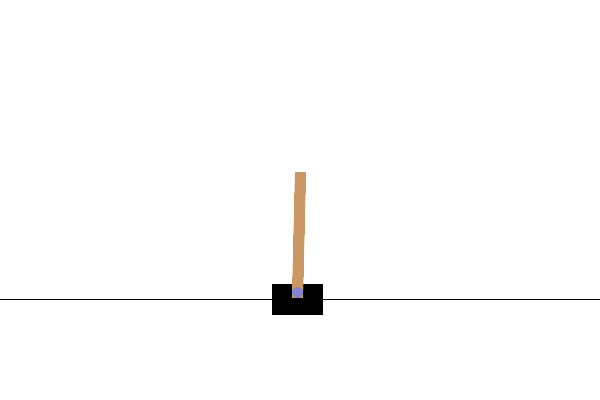

In [32]:
visualize_agent_gif(loaded_actor, eval_env, episodes=1, delay=0.0, gif_path="agent_2.gif")

# N step Updates

In [71]:
n_step = 5
gamma = 0.99
actor_lr = 5e-4
critic_lr = 1e-3
entropy_coef = 0.01


In [72]:
#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

episodes = 300
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr)

Ep 000 | Reward:   53 | Actor: 3.274 | Critic: 30.584 | Entropy: 0.681
Ep 001 | Reward:   31 | Actor: 2.794 | Critic: 26.696 | Entropy: 0.673
Ep 002 | Reward:   46 | Actor: 3.164 | Critic: 30.346 | Entropy: 0.686
Ep 003 | Reward:   21 | Actor: 2.436 | Critic: 25.512 | Entropy: 0.677
Ep 004 | Reward:   75 | Actor: 3.153 | Critic: 31.407 | Entropy: 0.690
Ep 005 | Reward:   25 | Actor: 2.717 | Critic: 24.505 | Entropy: 0.664
Ep 006 | Reward:   52 | Actor: 2.775 | Critic: 29.683 | Entropy: 0.681
Ep 007 | Reward:   19 | Actor: 2.636 | Critic: 25.429 | Entropy: 0.690
Ep 008 | Reward:   52 | Actor: 2.602 | Critic: 29.043 | Entropy: 0.678
Ep 009 | Reward:   53 | Actor: 2.787 | Critic: 28.349 | Entropy: 0.687
Ep 010 | Reward:   14 | Actor: 1.918 | Critic: 20.930 | Entropy: 0.608
Ep 011 | Reward:   33 | Actor: 2.276 | Critic: 30.501 | Entropy: 0.678
Ep 012 | Reward:   29 | Actor: 2.363 | Critic: 23.970 | Entropy: 0.689
Ep 013 | Reward:   35 | Actor: 2.531 | Critic: 35.402 | Entropy: 0.679
Ep 014

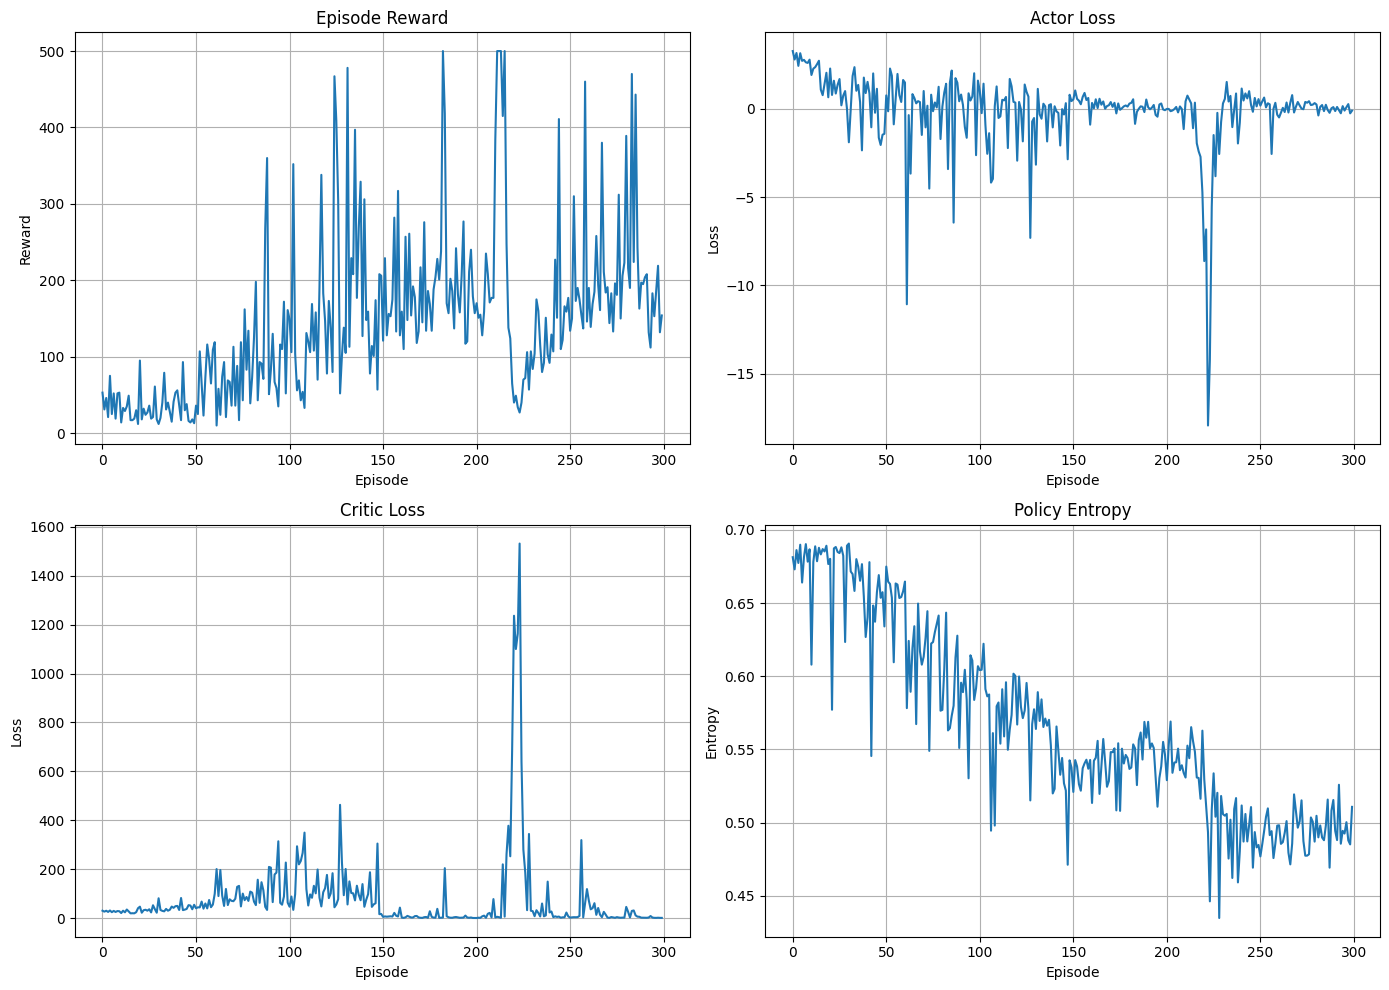

In [84]:
n_step = 10
gamma = 0.99
actor_lr = 1e-3
critic_lr = 3e-3
entropy_coef = 0.01

#setting up the env
env = gym.make("CartPole-v1")
actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0])

episodes = 300
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr)

entropy_coef = 0.0
# Storage for logs
reward_log = []
actor_loss_log = []
critic_loss_log = []
entropy_log = []

for episode in range(episodes):

    state, _ = env.reset()
    done = False

    episode_reward = 0
    episode_actor_loss = 0
    episode_critic_loss = 0
    episode_entropy = 0
    update_steps = 0

    log_probs, entropies, values, rewards = [], [], [], []

    entropy_coef = max(0.0, 0.01 * (1 - episode / episodes))

    while not done:

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action, log_prob, entropy = select_action(actor, state_tensor)
        value = critic(state_tensor)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        log_probs.append(log_prob)
        entropies.append(entropy)
        values.append(value)
        rewards.append(reward)

        episode_reward += reward
        state = next_state

        if len(rewards) >= n_step or terminated:

            with torch.no_grad():
                if terminated:
                    R = torch.zeros(1, 1)
                else:
                    next_state_tensor = torch.tensor(
                        next_state, dtype=torch.float32
                    ).unsqueeze(0)
                    R = critic(next_state_tensor)

            returns = []
            for r in reversed(rewards):
                R = r + gamma * R
                returns.insert(0, R)

            returns = torch.cat(returns)
            values_t = torch.cat(values)

            advantages = returns - values_t

            actor_loss = -(torch.cat(log_probs) * advantages.detach()).mean() - entropy_coef * torch.cat(entropies).mean()

            critic_loss = advantages.pow(2).mean()

            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()

            actor_loss.backward()
            critic_loss.backward()

            # torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
            # torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)

            actor_optimizer.step()
            critic_optimizer.step()

            episode_actor_loss += actor_loss.item()
            episode_critic_loss += critic_loss.item()
            episode_entropy += torch.cat(entropies).mean().item()
            update_steps += 1

            log_probs, entropies, values, rewards = [], [], [], []

    # ---- Episode logging ----
    reward_log.append(episode_reward)
    actor_loss_log.append(episode_actor_loss / max(1, update_steps))
    critic_loss_log.append(episode_critic_loss / max(1, update_steps))
    entropy_log.append(episode_entropy / max(1, update_steps))

    print(
        f"Ep {episode:03d} | "
        f"Reward: {episode_reward:4.0f} | "
        f"Actor: {actor_loss_log[-1]:.3f} | "
        f"Critic: {critic_loss_log[-1]:.3f} | "
        f"Entropy: {entropy_log[-1]:.3f}"
    )

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(reward_log)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(actor_loss_log)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(critic_loss_log)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(entropy_log)
plt.title("Policy Entropy")
plt.xlabel("Episode")
plt.ylabel("Entropy")
plt.grid(True)

plt.tight_layout()
plt.show()


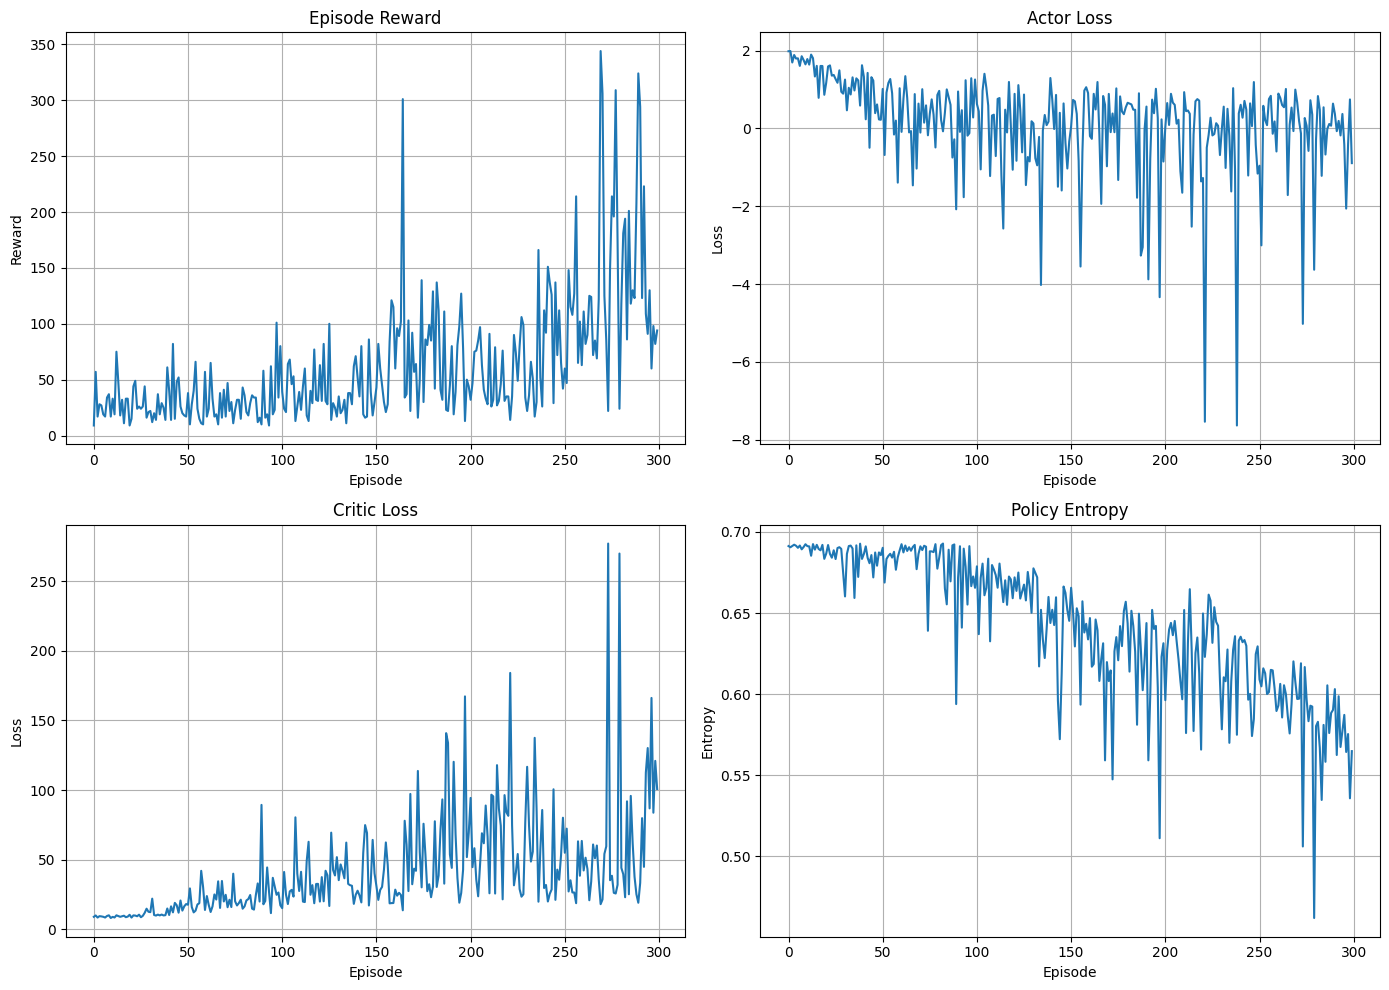

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(reward_log)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(actor_loss_log)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(critic_loss_log)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(entropy_log)
plt.title("Policy Entropy")
plt.xlabel("Episode")
plt.ylabel("Entropy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [77]:
import torch

# Define the file paths
ACTOR_PATH = "actor_model_n_step.pth"
CRITIC_PATH = "critic_model_n_step.pth"

# Save the state dictionaries
torch.save(actor.state_dict(), ACTOR_PATH)
torch.save(critic.state_dict(), CRITIC_PATH)

print(f"Models saved to {ACTOR_PATH} and {CRITIC_PATH}")

Models saved to actor_model_n_step.pth and critic_model_n_step.pth


In [78]:
# 1. Re-create the model architectures
loaded_actor = Actor(env.observation_space.shape[0], env.action_space.n)
loaded_critic = Critic(env.observation_space.shape[0])

# 2. Load the saved weights
loaded_actor.load_state_dict(torch.load("model_pth/actor_model_n_step.pth"))
loaded_critic.load_state_dict(torch.load("model_pth/critic_model_n_step.pth"))

# 3. Set to evaluation mode if only using for inference
loaded_actor.eval()
loaded_critic.eval()

C:\Users\91930\AppData\Local\Temp\ipykernel_15708\4269663910.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_actor.load_state_dict(torch.load("model_pth/actor_mod

Critic(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [79]:
# Set networks to evaluation mode
# actor.eval()
# critic.eval()

eval_env = gym.make("CartPole-v1", render_mode="rgb_array")
num_eval_episodes = 5
eval_rewards = []

for episode in range(num_eval_episodes):
    state, _ = eval_env.reset()
    done = False
    episode_reward = 0

    while not done:
        eval_env.render()
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():  # no grads needed
            logits = loaded_actor(state_tensor)
            # Take deterministic action: argmax
            action = torch.argmax(logits, dim=1).item()
            value = loaded_critic(state_tensor)

        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state

    eval_rewards.append(episode_reward)
    print(f"Eval Episode {episode}, Reward: {episode_reward}")

mean_reward = sum(eval_rewards)/num_eval_episodes
print(f"Average Reward over {num_eval_episodes} episodes: {mean_reward}")

# Optional: render

# eval_env.reset()


Eval Episode 0, Reward: 500.0
Eval Episode 1, Reward: 500.0
Eval Episode 2, Reward: 500.0
Eval Episode 3, Reward: 500.0
Eval Episode 4, Reward: 500.0
Average Reward over 5 episodes: 500.0


Episode 1, Reward: 500.0
Saved GIF to agent_2.gif


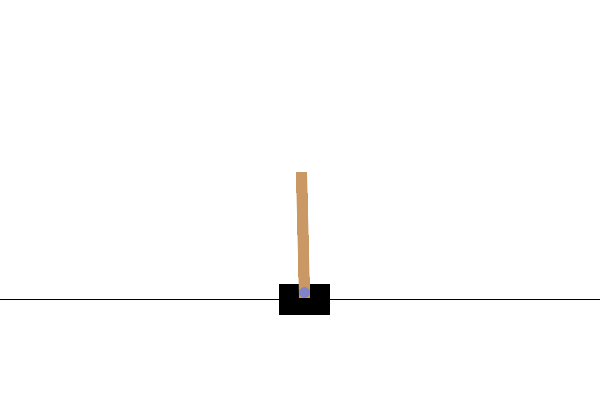

In [82]:
visualize_agent_gif(loaded_actor, eval_env, episodes=1, delay=0.0, gif_path="agent_2.gif")